In [1]:
import arviz as az
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal
from numpyro.infer.util import log_density
from scipy.interpolate import InterpolatedUnivariateSpline

from stream_membership import ComponentMixtureModel, ModelComponent
from stream_membership.distributions import IndependentGMM, TruncatedNormalSpline
from stream_membership.plot import plot_data_projections

## Simulate data

First we generate some simulated data to have a similar complexity to real stream data.

In [2]:
phi1_lim = (-100, 20)
phi2_lim = (-8, 4)
pm1_lim = (None, -2.0)

In [3]:
N_data = 8192

# first, the background:
keys = jax.random.split(jax.random.PRNGKey(42), num=9)
N = int(N_data * 0.55)
data = {
    "phi1": dist.TruncatedNormal(
        loc=-70, scale=30, low=phi1_lim[0], high=phi1_lim[1]
    ).sample(keys[1], (N,)),
    "phi2": dist.Uniform(*phi2_lim).sample(keys[2], (N,)),
}
true_pm1_loc_spl = InterpolatedUnivariateSpline(
    [-100, -20, 0.0, 20], [-5.0, -1.0, 2.0, 5.0]
)
true_pm1_scale = 2.0
data["pm1"] = dist.TruncatedNormal(
    loc=true_pm1_loc_spl(data["phi1"]), scale=2, high=pm1_lim[1]
).sample(keys[3])

# now, add a "stream":
keys = jax.random.split(jax.random.PRNGKey(412), num=6)
N_stream = int(0.85 * (N_data - N))
stream_data = {}
true_phi1_loc = -20.0
true_phi1_scale = 40.0
stream_data["phi1"] = dist.TruncatedNormal(
    loc=-20, scale=40, low=phi1_lim[0], high=phi1_lim[1]
).sample(keys[1], (N_stream,))

true_phi2_loc_spl = InterpolatedUnivariateSpline(
    [-100, -60, -20, 0, 20], [-6, -2, 0, 0, -1], k=3
)
true_phi2_ln_scale_spl = InterpolatedUnivariateSpline(
    [-100, -60, -20, 0, 20], np.log([0.8, 0.6, 0.5, 0.5, 0.8]), k=3
)
stream_data["phi2"] = TruncatedNormalSpline(
    loc_vals=[-6, -2, 0, 0, -1],
    scale_vals=[0.8, 0.6, 0.5, 0.5, 0.8],
    knots=[-100, -60, -20, 0, 20],
    low=phi2_lim[0],
    high=phi2_lim[1],
    x=stream_data["phi1"],
).sample(keys[2])

true_pm1_loc_spl = InterpolatedUnivariateSpline(
    [-100, -60, -20, 0, 20], [-3, -6, -9, -6, -4], k=3
)
true_pm1_ln_scale = np.log(0.05)
stream_data["pm1"] = TruncatedNormalSpline(
    loc_vals=[-3, -6, -9, -6, -4],
    scale_vals=np.full(5, 0.05),
    knots=[-100, -60, -20, 0, 20],
    low=pm1_lim[0],
    high=pm1_lim[1],
    x=stream_data["phi1"],
).sample(keys[3])

# Optionally: add an "off-track" feature
N_offrack = N_data - N - N_stream
offtrack = {}
offtrack["phi1"] = dist.TruncatedNormal(
    loc=-30, scale=6, low=phi1_lim[0], high=phi1_lim[1]
).sample(keys[4], (N_offrack,))

offtrack["phi2"] = TruncatedNormalSpline(
    loc_vals=np.array([-6.0, -2.0, 0.5, 2, 2.5, 2.5]),
    scale_vals=np.full(6, 0.3),
    knots=[-100, -60, -40, -20, 0, 20],
    low=phi2_lim[0],
    high=phi2_lim[1],
    x=offtrack["phi1"],
).sample(keys[5])

offtrack["pm1"] = TruncatedNormalSpline(
    loc_vals=[-3, -6, -9, -6, -4],
    scale_vals=np.full(5, 0.05),
    knots=[-100, -60, -20, 0, 20],
    low=pm1_lim[0],
    high=pm1_lim[1],
    x=offtrack["phi1"],
).sample(keys[6])

data = {k: jnp.concatenate([data[k], stream_data[k], offtrack[k]]) for k in data}
print(N_data, N, N_stream, N_offrack)

pm1_err = jnp.exp(jax.random.uniform(keys[7], minval=-5, maxval=0, shape=(N_data,)))
data["pm1"] = jax.random.normal(keys[8], shape=(N_data,)) * pm1_err + data["pm1"]
err = {"pm1": pm1_err}

mask = data["pm1"] < pm1_lim[1]
data = {k: data[k][mask] for k in data}
err = {k: err[k][mask] for k in err}
print(data["phi1"].shape[0])

8192 4505 3133 554
8017


Text(0.5, 0.98, 'simulated data')

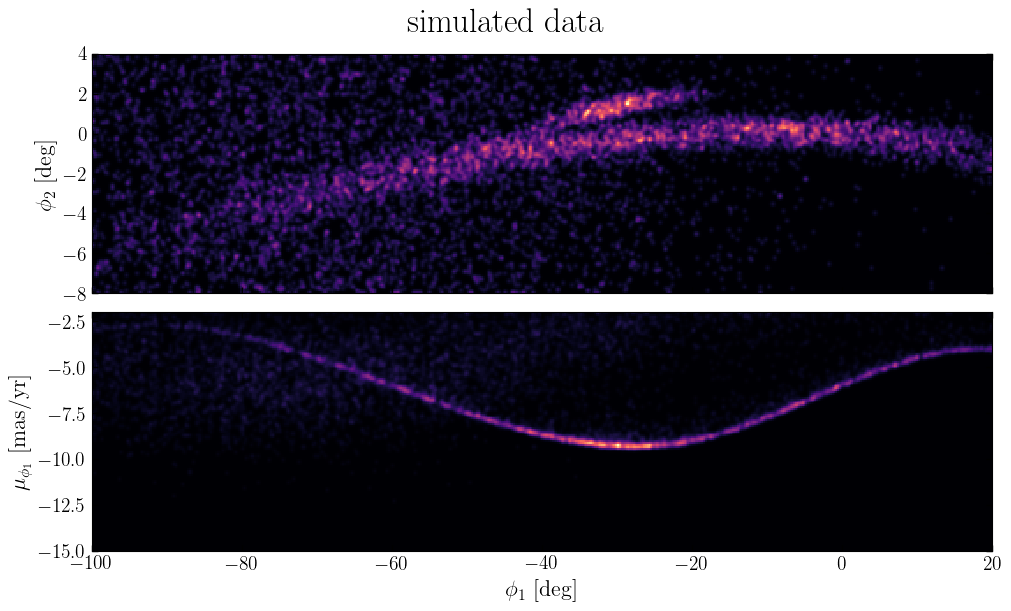

In [4]:
plot_grids = {
    "phi1": jnp.linspace(*phi1_lim, 512),
    "phi2": jnp.linspace(*phi2_lim, 128),
    "pm1": jnp.linspace(-15, pm1_lim[1], 128),
}
fig, axes, _ = plot_data_projections(data, grids=plot_grids)
fig.suptitle("simulated data", fontsize=24)

## Background model component

The sky distribution is represented by a grid of 2D Normal distributions. The grid Normal components have different learned scales for the $\phi_1$ and $\phi_2$ directions. The proper motion track is a truncated Normal with a mean and log-stddev that are spline functions of $\phi_1$.

In [5]:
bkg_pm1_knots = jnp.arange(-100, 20 + 1e-3, 30)

bkg_model = ModelComponent(
    name="background",
    coord_distributions={
        "phi1": dist.TruncatedNormal,
        "phi2": dist.Uniform,
        "pm1": TruncatedNormalSpline,
    },
    coord_parameters={
        "phi1": {
            "loc": dist.Normal(-70.0, 50.0),
            "scale": dist.HalfNormal(50.0),
            "low": phi1_lim[0],
            "high": phi1_lim[1],
        },
        "phi2": {
            "low": phi2_lim[0],
            "high": phi2_lim[1],
        },
        "pm1": {
            "loc_vals": dist.Normal(pm1_lim[1], 1.0).expand([bkg_pm1_knots.shape[0]]),
            "scale_vals": dist.HalfNormal(5).expand([bkg_pm1_knots.shape[0]]),
            "knots": bkg_pm1_knots,
            "x": data["phi1"],
            "low": pm1_lim[0],
            "high": pm1_lim[1],
            "spline_k": 3,
            "clip_locs": (-10, pm1_lim[1]),
            "clip_scales": (1e-3, None),
        },
    },
    conditional_data={"pm1": {"x": "phi1"}},
)

In [6]:
bkg_init_params = {
    "phi1": {"loc": -70.0, "scale": 30.0},
    "phi2": {},
    "pm1": {
        "loc_vals": jnp.full(bkg_pm1_knots.shape[0], -5.0),
        "scale_vals": jnp.full(bkg_pm1_knots.shape[0], 5.0),
    },
}

In [24]:
bkg_init_params

{'phi1': {'loc': -70.0, 'scale': 30.0},
 'phi2': {},
 'pm1': {'loc_vals': Array([-5., -5., -5., -5., -5.], dtype=float64, weak_type=True),
  'scale_vals': Array([5., 5., 5., 5., 5.], dtype=float64, weak_type=True)}}

Evaluate the background model at the initial parameters:

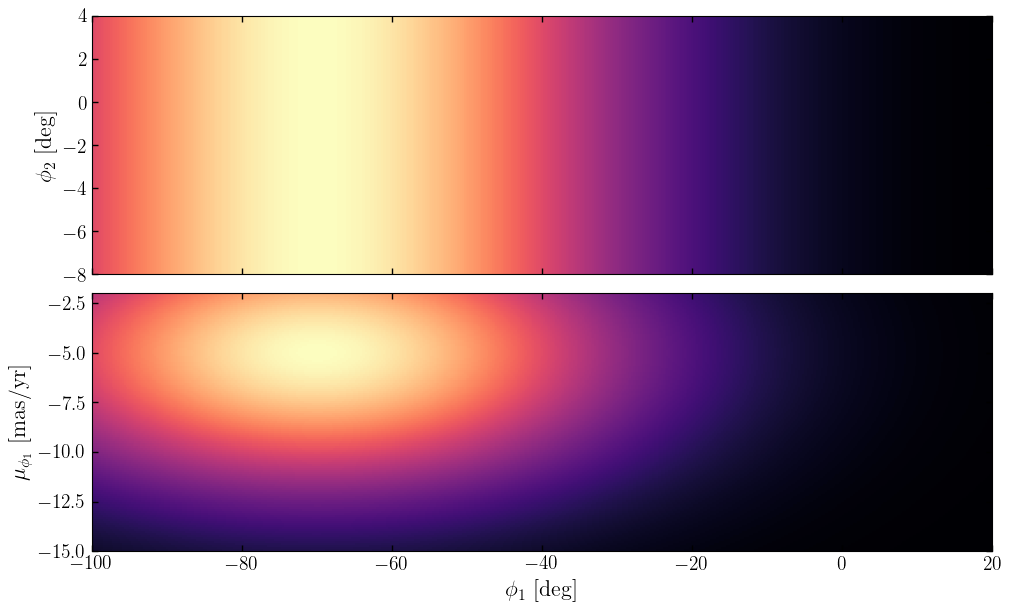

In [7]:
_ = bkg_model.plot_model_projections(bkg_init_params, grids=plot_grids)

## Stream model component

The stream model is defined using a 1D mixture of Normal distributions for the $\phi_1$ density, and conditional Normal distributions for $\phi_2$ and $\mu_1$ tracks. 

In [8]:
stream_phi1_knots = jnp.arange(-100.0, 20 + 1e-3, 10)
stream_phi2_knots = jnp.arange(-100.0, 20 + 1e-3, 15)
stream_pm1_knots = jnp.arange(-100.0, 20 + 1e-3, 15)

pm1_knots = jnp.arange(-100.0, 20 + 1e-3, 15)
stream_model = ModelComponent(
    name="stream",
    coord_distributions={
        "phi1": IndependentGMM,
        "phi2": TruncatedNormalSpline,
        "pm1": TruncatedNormalSpline,
    },
    coord_parameters={
        "phi1": {
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(len(stream_phi1_knots))),
            ),
            "locs": stream_phi1_knots.reshape(1, -1),
            "scales": dist.HalfNormal(5.0),
            "low": jnp.array([phi1_lim[0]])[:, None],
            "high": jnp.array([phi1_lim[1]])[:, None],
        },
        "phi2": {
            "loc_vals": dist.Uniform(*phi2_lim).expand([stream_phi2_knots.shape[0]]),
            "scale_vals": dist.HalfNormal(0.25).expand([stream_phi2_knots.shape[0]]),
            "knots": stream_phi2_knots,
            "x": data["phi1"],
            "low": phi2_lim[0],
            "high": phi2_lim[1],
            "spline_k": 3,
            "clip_scales": (1e-3, None),
        },
        "pm1": {
            "loc_vals": dist.Uniform(-15, pm1_lim[1]).expand(
                [stream_pm1_knots.shape[0]]
            ),
            "scale_vals": dist.HalfNormal(1.0),
            "knots": stream_pm1_knots,
            "x": data["phi1"],
            "low": pm1_lim[0],
            "high": pm1_lim[1],
            "spline_k": 3,
            "clip_locs": (-10.0, pm1_lim[1]),
            "clip_scales": (1e-3, None),
        },
    },
    conditional_data={"phi2": {"x": "phi1"}, "pm1": {"x": "phi1"}},
)

In [9]:
stream_init_params = {
    "phi1": {
        "mixing_distribution": jnp.ones(len(stream_phi1_knots))
        / len(stream_phi1_knots),
        "scales": 10.0,
    },
    "phi2": {
        "loc_vals": jnp.full(stream_phi2_knots.shape[0], 0.0),
        "scale_vals": jnp.full(stream_phi2_knots.shape[0], 0.5),
    },
    "pm1": {
        "loc_vals": jnp.full(stream_pm1_knots.shape[0], -5.0),
        "scale_vals": 0.1,
    },
}

Evaluate the stream model at the initial parameters:

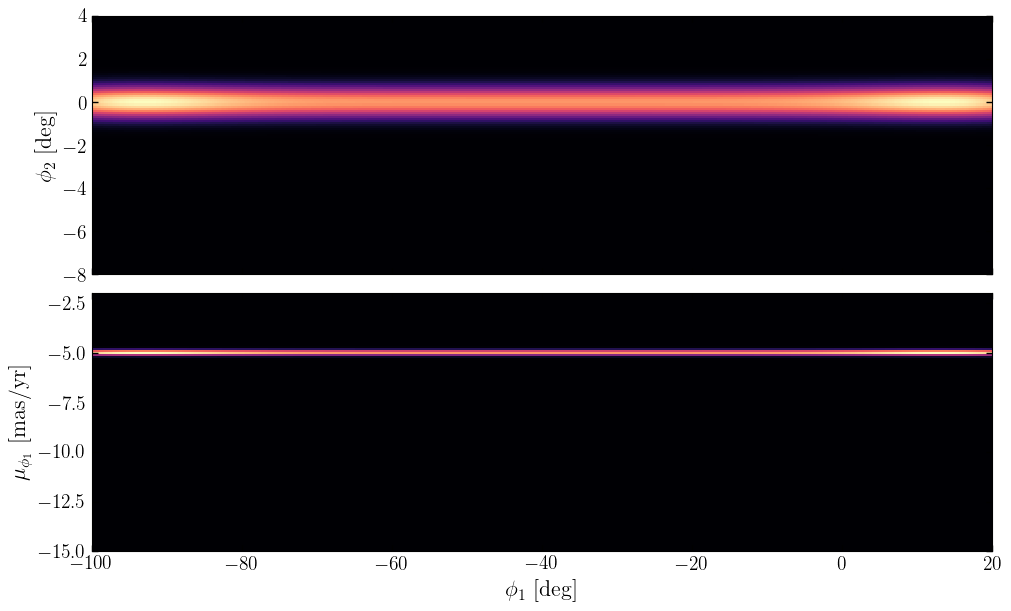

In [10]:
_ = stream_model.plot_model_projections(stream_init_params, grids=plot_grids)

Optimize the model with just stream and background components first:

In [11]:
stream_bkg_mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0])), components=[bkg_model, stream_model]
)

Visualize the model at initialization:

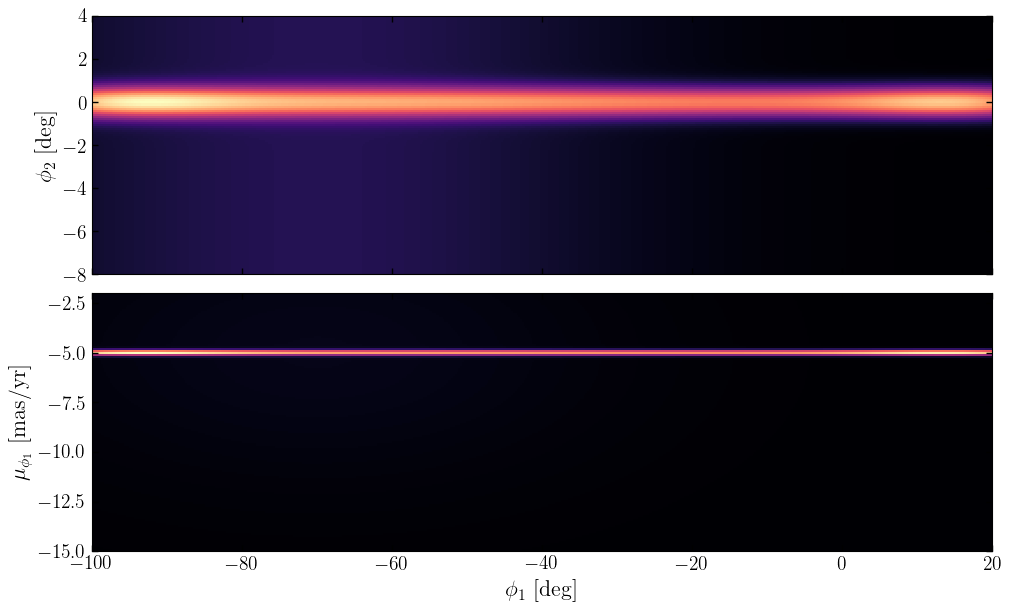

In [12]:
init_params = {"background": bkg_init_params, "stream": stream_init_params}
packed_params = stream_bkg_mm.pack_params(init_params)
packed_params["mixture-probs"] = jnp.array([0.5, 0.5])
packed_params["mixture"] = jnp.stack([v for v in data.values()], axis=-1)

_ = stream_bkg_mm.plot_model_projections(packed_params, grids=plot_grids)

In [13]:
optimizer = numpyro.optim.Adam(1e-2)
guide1 = AutoDelta(
    stream_bkg_mm, init_loc_fn=numpyro.infer.init_to_value(values=packed_params)
)
MAP_svi1 = SVI(stream_bkg_mm, guide1, optimizer, Trace_ELBO())


In [23]:
rng_key = jax.random.PRNGKey(12345)
with numpyro.validation_enabled(), jax.debug_nans():
    init_state = MAP_svi1.init(rng_key, init_params=packed_params, data=data, err=err)
    MAP_svi_results1 = MAP_svi1.run(
    rng_key=jax.random.PRNGKey(54321), num_steps=5000, init_state=init_state, data=data, err=err
    )

100%|█| 5000/5000 [04:42<00:00, 17.70it/s, init loss: -103485479.0222


In [20]:
MAP_svi_results1.params

{'background:phi1:loc_auto_loc': Array(-68.87580111, dtype=float64),
 'background:phi1:scale_auto_loc': Array(35.56047001, dtype=float64),
 'background:pm1:loc_vals_auto_loc': Array([-4.12560638, -5.46310211, -3.77395554, -3.07289256, -2.32272451],      dtype=float64),
 'background:pm1:scale_vals_auto_loc': Array([2.80921776, 1.96013488, 2.64029596, 2.91580829, 0.39415964],      dtype=float64),
 'mixture-probs_auto_loc': Array([0.6248383, 0.3751617], dtype=float64),
 'mixture_auto_loc': Array([[-50.31722184,  -6.88506396,  -6.6216871 ],
        [-94.24238882,  -0.38865461,  -5.88304328],
        [-56.16692793,  -2.82599049,  -6.5322543 ],
        ...,
        [-21.44355276,   2.43579241,  -8.92657975],
        [-31.95215353,   1.46383711,  -9.1759032 ],
        [-34.29376176,   0.84623846,  -9.15042621]], dtype=float64),
 'stream:phi1:mixing_distribution_auto_loc': Array([0.00720863, 0.00758622, 0.00644827, 0.01173642, 0.03049377,
        0.06181148, 0.41189926, 0.04694597, 0.03222151,

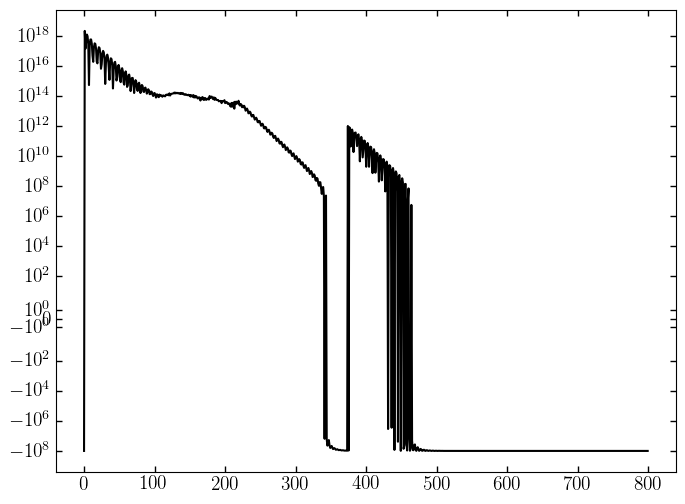

In [21]:
plt.plot(MAP_svi_results1.losses)
plt.yscale("symlog")

thing = Predictive(guide1, params=MAP_svi_results1.params, num_samples=1)
MAP_p1 = thing(keys[1], data=data)
MAP_p1 = {k: v[0] for k, v in MAP_p1.items()}
MAP_p1_expanded = stream_bkg_mm.expand_numpyro_params(MAP_p1)

In [27]:
MAP_p1_expanded

{'background': {'phi1': {'loc': Array(-68.87580111, dtype=float64),
   'scale': Array(35.56047001, dtype=float64)},
  'pm1': {'loc_vals': Array([-4.12560638, -5.46310211, -3.77395554, -3.07289256, -2.32272451],      dtype=float64),
   'scale_vals': Array([2.80921776, 1.96013488, 2.64029596, 2.91580829, 0.39415964],      dtype=float64)}},
 'stream': {'phi1': {'mixing_distribution': Array([0.00720863, 0.00758622, 0.00644827, 0.01173642, 0.03049377,
          0.06181148, 0.41189926, 0.04694597, 0.03222151, 0.20430486,
          0.12781899, 0.03575302, 0.01577161], dtype=float64),
   'scales': Array(19.83616111, dtype=float64)},
  'phi2': {'loc_vals': Array([-6.34217867, -4.33519328, -2.84987327, -1.71024749, -0.36870862,
           0.57917008,  0.11973706, -0.05898531, -1.35276673], dtype=float64),
   'scale_vals': Array([0.54319773, 0.65420113, 0.61858421, 0.58239991, 0.65994005,
          1.00734764, 0.45828976, 0.57071183, 0.54640674], dtype=float64)},
  'pm1': {'loc_vals': Array([-2.9

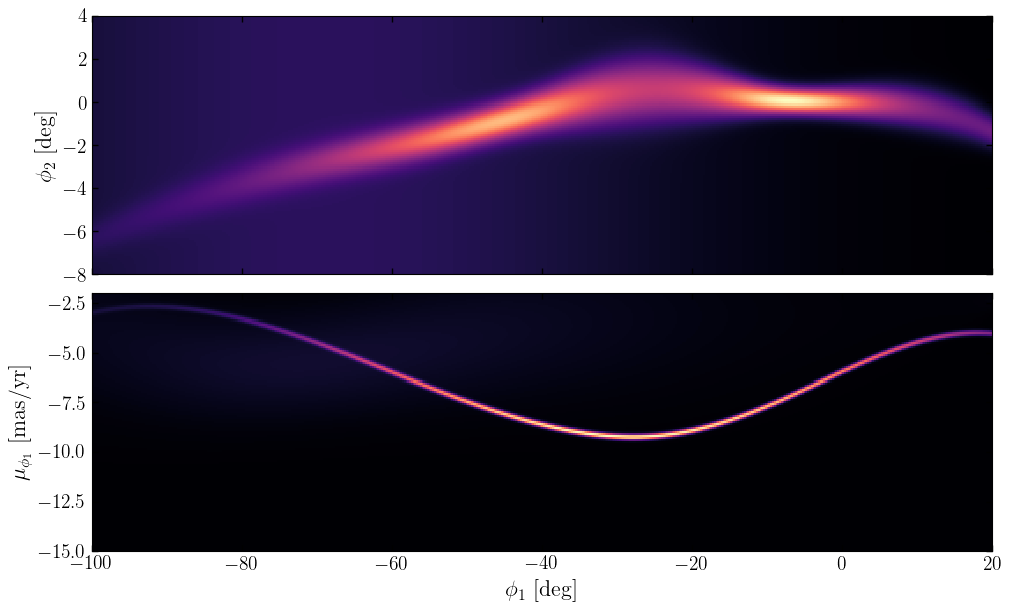

In [25]:
_ = stream_bkg_mm.plot_model_projections(MAP_p1, plot_grids)

## Off-track model component

**Note: Code below here is currently failing and is a mess! I'm working on it...**

We also include an "off-track" model that uses the 2D grid of Normals for the sky distribution but uses the same $\mu_1$ track as the stream model. 

In [18]:
offtrack_phi1_dx = 1.0
offtrack_phi2_dx = 0.25
offtrack_phi12_locs = jnp.stack(
    jnp.meshgrid(
        jnp.arange(-50.0, -15.0 + 1e-3, offtrack_phi1_dx),
        jnp.arange(-2.0, 3.0 + 1e-3, offtrack_phi2_dx),
    ),
    axis=-1,
).reshape(-1, 2)

# Remove nodes in areas we don't have data:
offtrack_node_mask = np.ones(offtrack_phi12_locs.shape[0], dtype=bool)
pt1 = (-55, 0)
pt2 = (-40, 2)
m = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0])
offtrack_node_mask &= offtrack_phi12_locs[:, 1] < (
    m * (offtrack_phi12_locs[:, 0] - pt1[0]) + pt1[1]
)
offtrack_node_mask &= offtrack_phi12_locs[:, 1] > (
    m * (offtrack_phi12_locs[:, 0] - pt1[0]) + pt1[1] - 4.0
)

offtrack_phi12_locs = offtrack_phi12_locs[offtrack_node_mask]
print(f"{offtrack_phi12_locs.shape[0]} nodes for offtrack model")

offtrack_model = ModelComponent(
    name="offtrack",
    coord_distributions={
        ("phi1", "phi2"): IndependentGMM,
        "pm1": stream_model.coord_distributions["pm1"],
    },
    coord_parameters={
        ("phi1", "phi2"): {
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.full(offtrack_phi12_locs.shape[0], 0.5)),
            ),
            "locs": offtrack_phi12_locs.T,
            "scales": dist.HalfNormal(
                jnp.array([offtrack_phi1_dx, offtrack_phi2_dx])[:, None]
            ),
            "low": jnp.array([phi1_lim[0], phi2_lim[0]])[:, None],
            "high": jnp.array([phi1_lim[1], phi2_lim[1]])[:, None],
        },
        # We don't need to define the parameters here, as they are the same as for the
        # stream model - this will be handled below when we combine the components into
        # a mixture model
        "pm1": stream_model.coord_parameters["pm1"],
    },
    conditional_data={"pm1": {"x": "phi1"}},
)

472 nodes for offtrack model


In [19]:
_init_prob = (
    np.exp(-0.5 * (offtrack_phi12_locs[:, 0] - -35) ** 2 / 4**2)
    * np.exp(-0.5 * (offtrack_phi12_locs[:, 1] - 1.5) ** 2 / 0.5**2)
    + 1e-5
)
_init_prob /= _init_prob.sum()

offtrack_init_params = {
    ("phi1", "phi2"): {
        "mixing_distribution": _init_prob,
        "scales": jnp.array([1.0, 0.25])[:, None],
    },
    "pm1": stream_init_params["pm1"],
}

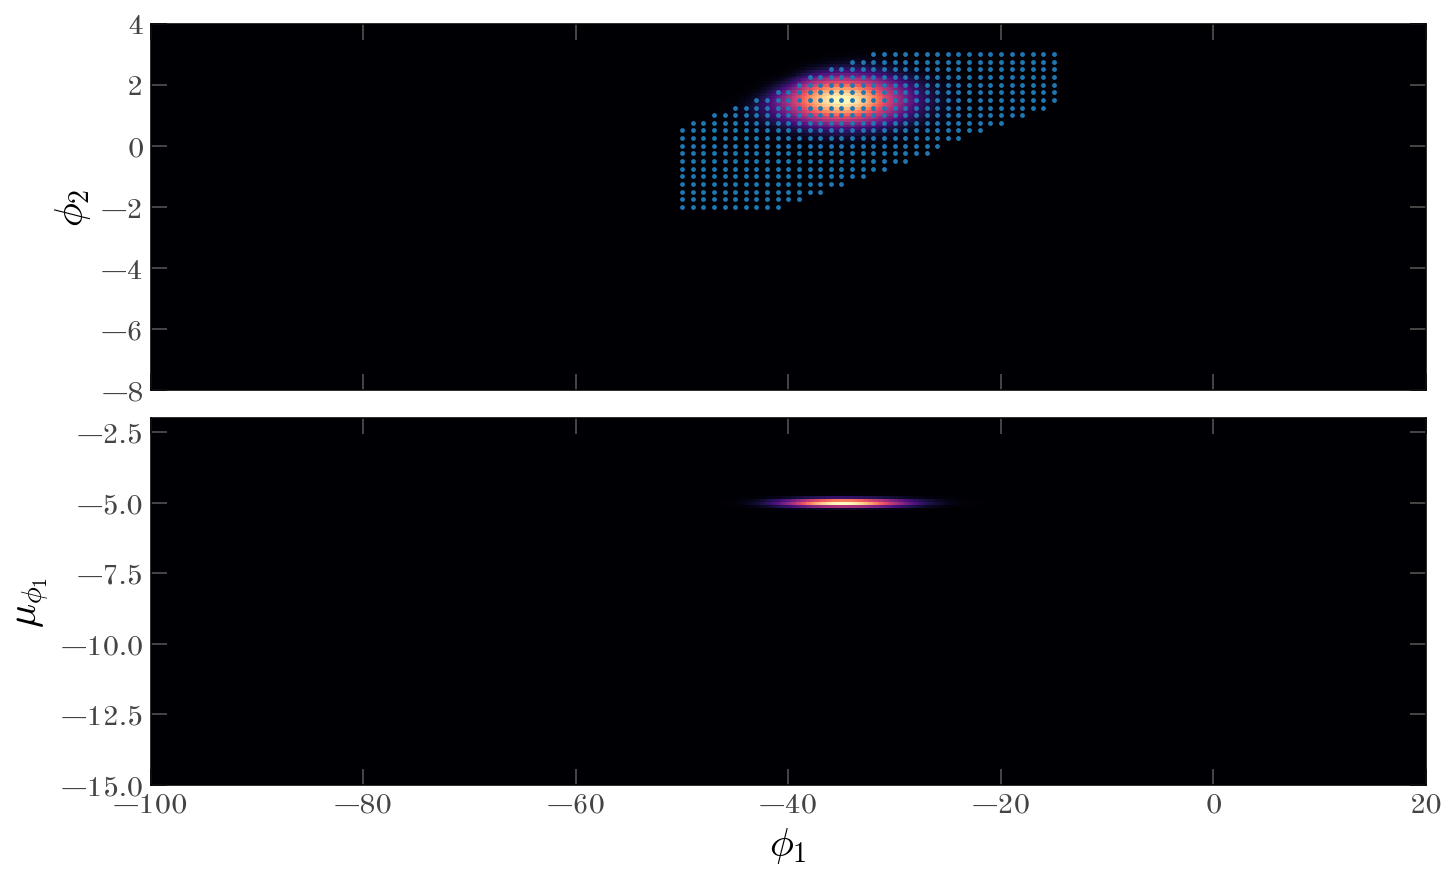

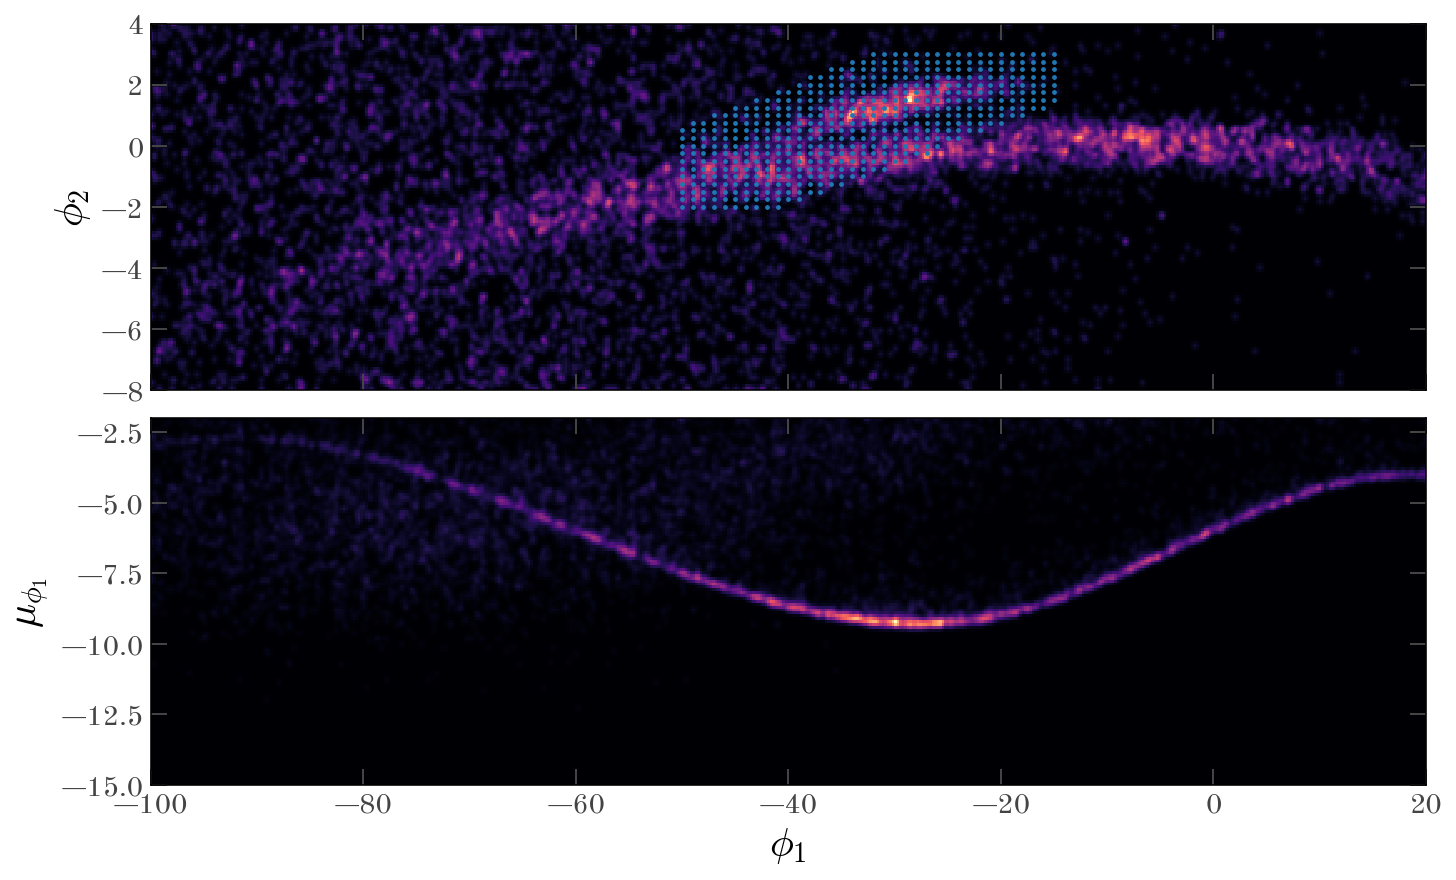

In [20]:
fig, axes = offtrack_model.plot_model_projections(
    offtrack_init_params, grids=plot_grids
)
axes[0].scatter(
    offtrack_phi12_locs[:, 0], offtrack_phi12_locs[:, 1], color="tab:blue", s=2
)

fig, axes = plot_data_projections(data, grids=plot_grids)
axes[0].scatter(
    offtrack_phi12_locs[:, 0], offtrack_phi12_locs[:, 1], color="tab:blue", s=2
)


Now that we have defined the three components of the model, we combine them into a mixture model. The mixture model is a mixture of the background, stream, and off-track models. The mixture weights are learned from the data. Note that we use the `tied_coordinates` argument to specify that the off-track model "pm1" ($\mu_1$) coordinate should be "tied" to the stream model:

In [21]:
mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0, 2.0])),
    components=[bkg_model, stream_model, offtrack_model],
    tied_coordinates={"offtrack": {"pm1": "stream"}},
)

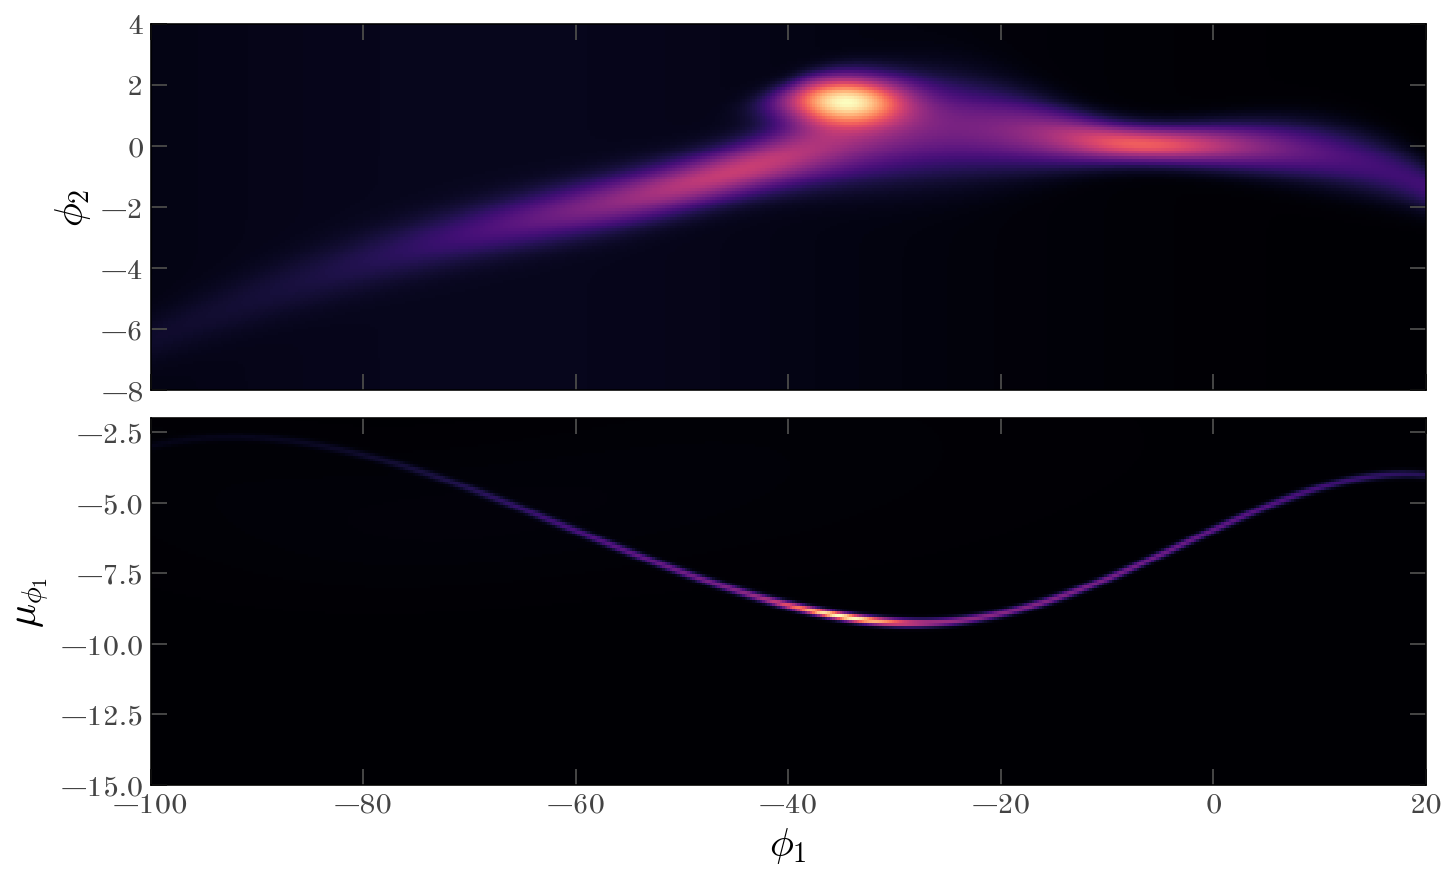

In [22]:
mm_init_params = {
    "background": MAP_p1_expanded["background"],
    "stream": MAP_p1_expanded["stream"],
    "offtrack": offtrack_init_params,
}
mm_packed_params = mm.pack_params(mm_init_params)
mm_packed_params["mixture-probs"] = jnp.array([0.4, 0.5, 0.1])
mm_packed_params["mixture"] = jnp.stack([v for v in data.values()], axis=-1)

_ = mm.plot_model_projections(mm_packed_params, grids=plot_grids)

In [31]:
# TODO: do we need to pass in unconstrained parameter values?
# optimizer = numpyro.optim.Adam(1e-3, eps=1e-11)
optimizer = numpyro.optim.ClippedAdam(1e-2, eps=1e-10)
guide = AutoDelta(mm, init_loc_fn=numpyro.infer.init_to_value(values=mm_packed_params))
MAP_svi = SVI(mm, guide, optimizer, Trace_ELBO())

In [32]:
keys = jax.random.split(jax.random.PRNGKey(808), num=2)
with numpyro.validation_enabled(), jax.debug_nans():
    init_state = MAP_svi.init(keys[0], init_params=mm_packed_params, data=data, err=err)
    MAP_svi_results = MAP_svi.run(
        keys[1], 1000, init_state=init_state, data=data, err=err
    )

 67%|██████▋   | 668/1000 [01:26<00:39,  8.33it/s, init loss: -103505372.7920, avg. loss [601-650]: 45859190785564464.0000]

--**-- probs min max = 0.0 0.9785277929025732
        probs = [2.65077417e-010 2.65082330e-010 2.65091044e-010 2.65096306e-010
 2.65099640e-010 2.65109570e-010 2.65121701e-010 2.65126017e-010
 2.65120688e-010 2.65109490e-010 2.65076651e-010 2.65075370e-010
 2.65085305e-010 2.65097302e-010 2.65104763e-010 2.65109810e-010
 2.65110981e-010 2.65104490e-010 2.65089388e-010 2.65074041e-010
 2.65062101e-010 2.65052306e-010 2.65082997e-010 2.65081602e-010
 2.65089724e-010 2.65101157e-010 2.65110356e-010 2.65118706e-010
 2.65126071e-010 2.65135385e-010 2.65154330e-010 2.65193000e-010
 2.65248499e-010 2.65311068e-010 2.65376182e-010 2.65428511e-010
 2.65093361e-010 2.65103815e-010 2.65127699e-010 2.65173777e-010
 2.65259602e-010 2.65410813e-010 2.65659680e-010 2.66046271e-010
 2.66613964e-010 2.67388210e-010 2.68347390e-010 2.69419968e-010
 2.70487475e-010 2.71396602e-010 2.72008504e-010 2.72225148e-010
 2.65179104e-010 2.65307601e-010 2.65591465e-010 2.66186108e-010
 2.67343379e-010 2.69431953e

 67%|██████▋   | 668/1000 [01:30<00:44,  7.39it/s, init loss: -103505372.7920, avg. loss [601-650]: 45859190785564464.0000]


FloatingPointError: invalid value (nan) encountered in jit(div). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/jax-ml/jax.

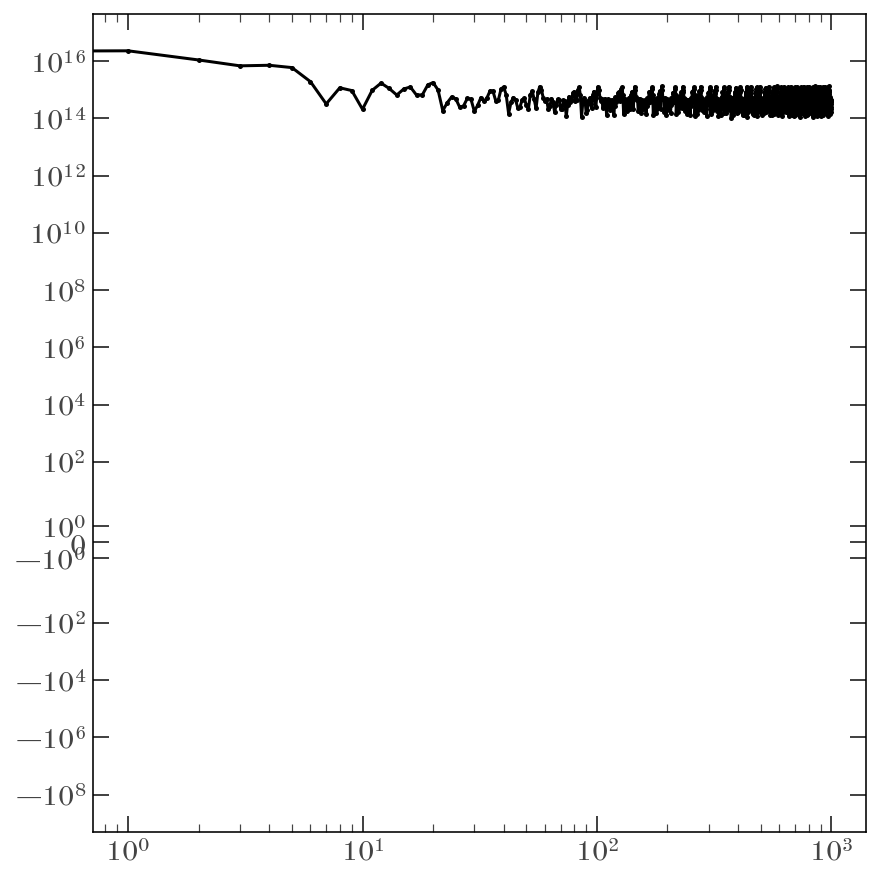

In [30]:
plt.semilogx(MAP_svi_results.losses)
plt.yscale("symlog")

thing = Predictive(guide, params=MAP_svi_results.params, num_samples=1)
MAP_p2 = thing(keys[1], data=data)
MAP_p2 = {k: v[0] for k, v in MAP_p2.items()}

In [83]:
MAP_p2_expanded = mm.expand_numpyro_params(MAP_p2)
MAP_p2_expanded["offtrack"]

{('phi1',
  'phi2'): {'mixing_distribution': Array([1.42233037e-009, 1.42234658e-009, 1.42237946e-009, 1.42239718e-009,
         1.42241035e-009, 1.42246398e-009, 1.42253240e-009, 1.42256208e-009,
         1.42254428e-009, 1.42250194e-009, 1.42233615e-009, 1.42232983e-009,
         1.42237450e-009, 1.42242756e-009, 1.42245949e-009, 1.42248258e-009,
         1.42248993e-009, 1.42246583e-009, 1.42240540e-009, 1.42234987e-009,
         1.42231970e-009, 1.42229836e-009, 1.42237165e-009, 1.42236586e-009,
         1.42240349e-009, 1.42245597e-009, 1.42249974e-009, 1.42254371e-009,
         1.42258765e-009, 1.42264859e-009, 1.42276226e-009, 1.42297762e-009,
         1.42328331e-009, 1.42362736e-009, 1.42398166e-009, 1.42426530e-009,
         1.42242701e-009, 1.42248331e-009, 1.42261000e-009, 1.42285507e-009,
         1.42331254e-009, 1.42412181e-009, 1.42545964e-009, 1.42754259e-009,
         1.43059665e-009, 1.43475207e-009, 1.43989591e-009, 1.44564791e-009,
         1.45137462e-009, 1.45625

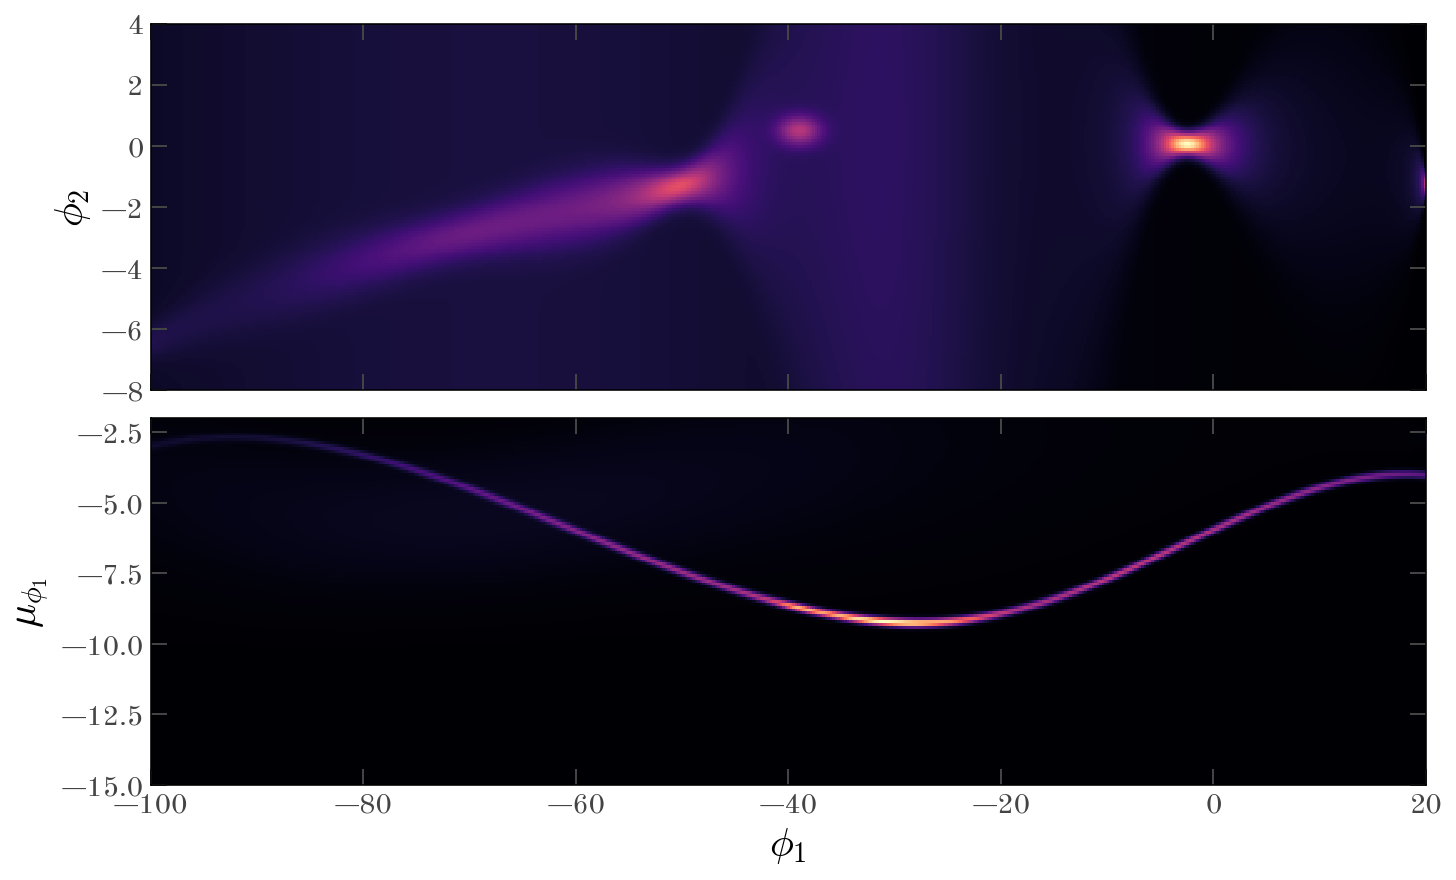

In [84]:
_ = mm.plot_model_projections(MAP_p2, plot_grids)

In [ ]:
plt.plot(stream_phi2_knots, exp_MAP_p["stream"]["phi2"]["scale_vals"])

In [ ]:
mm["stream"].plot_model_projections(exp_MAP_p["stream"], plot_grids)

In [ ]:
mm["offtrack"].plot_model_projections(exp_MAP_p["offtrack"], plot_grids)

In [ ]:
fig, axes = plot_data_projections(data, grids=plot_grids)

In [ ]:
pp = mm["offtrack"].expand_numpyro_params(MAP_p, skip_invalid=True)
# mm["offtrack"].plot_model_projections(
#     pp, plot_grids, pcolormesh_kwargs={"norm": mpl.colors.LogNorm()}
# )
pp

In [60]:
from stream_membership.model import CoordinateMapping

In [ ]:
def shit(pars):
    gmm = offtrack_model.make_dists(pars)[("phi1", "phi2")]
    return jnp.sum(gmm.log_prob(jnp.stack((data['phi1'], data['phi2']), axis=-1)))

pp = CoordinateMapping(offtrack_init_params)
# shit(pp)
jax.grad(shit)(pp)

In [ ]:
from functools import partial
from numpyro.handlers import seed, substitute, trace
from numpyro.infer.util import (
    _get_model_transforms,
    get_potential_fn,
    transform_fn,
    _init_to_unconstrained_value,
    find_valid_initial_params,
    potential_energy,
    _unconstrain_reparam,
)


def custom_log_density(model, model_args, model_kwargs, params):
    from jax.lax import broadcast_shapes
    from numpyro.infer.util import is_identically_one

    model = substitute(model, data=params)
    model_trace = trace(model).get_trace(*model_args, **model_kwargs)
    log_joint = jnp.zeros(())
    for site in model_trace.values():
        if site["type"] == "sample":
            value = site["value"]
            intermediates = site["intermediates"]
            scale = site["scale"]
            if intermediates:
                log_prob = site["fn"].log_prob(value, intermediates)
            else:
                guide_shape = jnp.shape(value)
                model_shape = tuple(
                    site["fn"].shape()
                )  # TensorShape from tfp needs casting to tuple
                try:
                    broadcast_shapes(guide_shape, model_shape)
                except ValueError:
                    raise ValueError(
                        "Model and guide shapes disagree at site: '{}': {} vs {}".format(
                            site["name"], model_shape, guide_shape
                        )
                    )
                log_prob = site["fn"].log_prob(value)

            if (scale is not None) and (not is_identically_one(scale)):
                log_prob = scale * log_prob

            # if site["name"] == "phi1-obs":
            # print(site["name"], value)
            # print(site["fn"])
            # try:
            #     print(site["name"], log_prob.primal)
            # except:
            #     print(site["name"], log_prob)
            log_prob = jnp.sum(log_prob)
            log_joint = log_joint + log_prob
    return log_joint, model_trace


def custom_potential_energy(model, model_args, model_kwargs, params, enum=False):
    log_density_ = custom_log_density

    substituted_model = substitute(
        model, substitute_fn=partial(_unconstrain_reparam, params)
    )
    # no param is needed for log_density computation because we already substitute
    log_joint, model_trace = log_density_(
        substituted_model, model_args, model_kwargs, {}
    )
    return -log_joint


rng_key = jax.random.PRNGKey(12345)
with numpyro.validation_enabled(), jax.debug_nans():
    model = mm
    model_args = ()
    model_kwargs = {"data": data, "err": err}
    init_strategy = numpyro.infer.init_to_value(values=packed_params)

    substituted_model = substitute(seed(model, rng_key), substitute_fn=init_strategy)
    (
        inv_transforms,
        replay_model,
        has_enumerate_support,
        model_trace,
    ) = _get_model_transforms(substituted_model, model_args, model_kwargs)

    model2 = substitute(
        model,
        data={
            k: site["value"]
            for k, site in model_trace.items()
            if site["type"] in ["param", "mutable"]
        },
    )
    # model2 = _substitute_default_key(model2)

    constrained_values = {
        k: v["value"]
        for k, v in model_trace.items()
        if v["type"] == "sample"
        and not v["is_observed"]
        and not v["fn"].support.is_discrete
    }

    potential_fn, postprocess_fn = get_potential_fn(
        model,
        inv_transforms,
        replay_model=replay_model,
        enum=has_enumerate_support,
        dynamic_args=False,
        model_args=model_args,
        model_kwargs=model_kwargs,
    )

    init_values = init_strategy.keywords.get("values")
    unconstrained_values = transform_fn(inv_transforms, init_values, invert=True)
    init_strategy = _init_to_unconstrained_value(values=unconstrained_values)

    prototype_params = transform_fn(inv_transforms, constrained_values, invert=True)

    print(
        "unconstrained_values",
        unconstrained_values["offtrack:phi1-phi2:mixing_distribution"].shape,
    )
    test = transform_fn(inv_transforms, unconstrained_values, invert=False)
    print(
        "test", test["offtrack:phi1-phi2:mixing_distribution"].shape, test["offtrack:phi1-phi2:mixing_distribution"].sum()
    )

    # APW: inside find_valid_initial_params
    radius = 2
    key, subkey = jax.random.split(jax.random.PRNGKey(929292))
    init_values = init_strategy.keywords.get("values")

    params = {}
    for k, v in prototype_params.items():
        if k in init_values:
            params[k] = init_values[k]
        else:
            print(k)
            params[k] = jax.random.uniform(
                subkey, jnp.shape(v), minval=-radius, maxval=radius
            )
            key, subkey = jax.random.split(key)
    potential_fn = partial(
        # potential_energy, model, model_args, model_kwargs, enum=False
        custom_potential_energy,
        model,
        model_args,
        model_kwargs,
        enum=False,
    )
    pe, z_grad = jax.value_and_grad(potential_fn)(params)
    print(params)
    # print("PE", pe)
    print("ZGRAD", z_grad)

    # (init_params, pe, grad), is_valid = find_valid_initial_params(
    #     rng_key,
    #     substitute(
    #         model,
    #         data={
    #             k: site["value"]
    #             for k, site in model_trace.items()
    #             if site["type"] in ["plate"]
    #         },
    #     ),
    #     init_strategy=init_strategy,
    #     enum=has_enumerate_support,
    #     model_args=model_args,
    #     model_kwargs=model_kwargs,
    #     prototype_params=prototype_params,
    #     forward_mode_differentiation=False,
    #     validate_grad=True,
    # )
    # print(is_valid)

In [ ]:
rng_key = jax.random.PRNGKey(12345)
with numpyro.validation_enabled():
    init_state = MAP_svi.init(rng_key, init_params=packed_params, data=data, err=err)

In [18]:
# # DEBUG
# key = jax.random.PRNGKey(42)
# optimizer = numpyro.optim.Adam(1e-1)
# guide = AutoDelta(
#     bkg_model, init_loc_fn=numpyro.infer.init_to_value(values=bkg_init_params)
# )
# MAP_svi = SVI(bkg_model, guide, optimizer, Trace_ELBO())

# # ---
# from numpyro.distributions.transforms import biject_to
# from numpyro.handlers import seed, substitute, trace
# from numpyro.infer.util import _unconstrain_reparam, log_density, transform_fn
# # init_strategy = numpyro.infer.init_to_sample()
# init_strategy = numpyro.infer.init_to_value(values=bkg_init_params)
# seeded_model = substitute(seed(bkg_model, key), substitute_fn=init_strategy)
# with numpyro.validation_enabled():
#     lp = log_density(
#         seeded_model, (), {"data": data, "err": err}, params=bkg_init_params
#     )
# # lp[0]  # THIS WORKS FINE

# model_trace = trace(seeded_model).get_trace(data=data, err=err)
# # model_trace  # THIS ALSO WORKS

# # ---
# # TODO: do init_params need to be the reparametrized / transformed ones???

# constrained_values, inv_transforms = {}, {}
# for k, v in model_trace.items():
#     if (
#         v["type"] == "sample"
#         and not v["is_observed"]
#         and not v["fn"].support.is_discrete
#     ):
#         constrained_values[k] = v["value"]
#         inv_transforms[k] = biject_to(v["fn"].support)
# params = transform_fn(
#     inv_transforms,
#     {k: v for k, v in constrained_values.items()},
#     invert=True,
# )

# with numpyro.validation_enabled():
#     rng_key = jax.random.PRNGKey(12345)
#     init_state = MAP_svi.init(rng_key, data=data, err=err, init_params=params)

TODO: Write a test to do a component and a mixture model of that 1 component. Should both have the same behavior.

In [19]:
optimizer = numpyro.optim.Adam(1e-1)
init_params = mm.pack_params(
    {
        "background": bkg_init_params,
        "stream": stream_init_params,
        # "offtrack": offtrack_init_params,
    }
)
# init_params["mixture-probs"] = jnp.array([0.4, 0.4, 0.2])
init_params["mixture-probs"] = jnp.array([0.4, 0.6])
init_params["mixture"] = np.stack(list(data.values()), axis=-1)
# for name in mm.coord_names:
#     init_params[f"{name}-obs"] = data[name]

guide = AutoDelta(mm, init_loc_fn=numpyro.infer.init_to_value(values=init_params))
MAP_svi = SVI(mm, guide, optimizer, Trace_ELBO())

In [ ]:
# TODO: why doesn't this work???

# model_ = stream_model
# params_ = stream_init_params
model_ = mm
params_ = init_params

guide = AutoDelta(model_, init_loc_fn=numpyro.infer.init_to_value(values=params_))
MAP_svi = SVI(model_, guide, optimizer, Trace_ELBO())

from numpyro.distributions.transforms import biject_to
from numpyro.handlers import seed, substitute, trace
from numpyro.infer.util import _unconstrain_reparam, log_density, transform_fn

# init_strategy = numpyro.infer.init_to_value(values=init_params)
# seeded_model = substitute(seed(mm, jax.random.PRNGKey(42)), substitute_fn=init_strategy)
init_strategy = numpyro.infer.init_to_value(values=params_)
seeded_model = substitute(
    seed(model_, jax.random.PRNGKey(42)), substitute_fn=init_strategy
)
seeded_model(data=data, err=err)
print("call seeded model")

model_trace = trace(seeded_model).get_trace(data=data, err=err)

# constrained_values, inv_transforms = {}, {}
# for k, v in model_trace.items():
#     if (
#         v["type"] == "sample"
#         and not v["is_observed"]
#         and not v["fn"].support.is_discrete
#     ):
#         constrained_values[k] = v["value"]
#         inv_transforms[k] = biject_to(v["fn"].support)
# init_params_transformed = transform_fn(inv_transforms, constrained_values, invert=True)

with numpyro.validation_enabled():
    rng_key = jax.random.PRNGKey(12345)
    init_state = MAP_svi.init(rng_key, data=data, init_params=params_)


# TODO: the problem is with _StackedModelComponent.__init__, I think! With a Uniform
# specification of pm1 scale as a scalar??

We now evaluate the log-probability of the model at the initial parameters to make sure everything is in order:

In [25]:
with numpyro.validation_enabled():
    rng_key = jax.random.PRNGKey(12345)
    thing = Predictive(mm, params=init_params, num_samples=1)
    MAP_p0 = thing(rng_key, data=data, err=err)
    MAP_p0 = {k: v[0] for k, v in MAP_p0.items()}

# MAP_p0

In [ ]:
mm.plot_model_projections(
    init_params, plot_grids, pcolormesh_kwargs={"norm": mpl.colors.LogNorm()}
)

In [ ]:
rng_key = jax.random.PRNGKey(54321)
keys = jax.random.split(rng_key, num=3)

MAP_svi_results = MAP_svi.run(
    keys[0],
    200,
    data=data,
    err=err,
    init_params=init_params,  # init_state=init_state
)
plt.plot(MAP_svi_results.losses)

In [38]:
thing = Predictive(guide, params=MAP_svi_results.params, num_samples=1)
MAP_p = thing(keys[1], data=data)
MAP_p = {k: v[0] for k, v in MAP_p.items()}

In [ ]:
MAP_p

In [ ]:
mm.plot_model_projections(MAP_p, plot_grids)
plot_data_projections(data, plot_grids)

In [ ]:
expanded_pars = mm.expand_numpyro_params(MAP_p)
for name in mm.component_names:
    mm._components[name].plot_model_projections(expanded_pars[name], plot_grids)

TODO: how to init guide at loc's given by MAP optimization?

In [ ]:
optimizer = numpyro.optim.Adam(1e-2)
guide = AutoNormal(mm, init_loc_fn=numpyro.infer.init_to_value(values=MAP_p))
svi = SVI(mm, guide, optimizer, Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(0), 10_000, data=data)
plt.loglog(svi_results.losses)

In [ ]:
rng_key = jax.random.PRNGKey(123)

thing = Predictive(guide, params=svi_results.params, num_samples=100)
SVI_ps = thing(rng_key, data=data)
SVI_p = {k: v[0] for k, v in SVI_ps.items()}

In [ ]:
SVI_p

In [ ]:
mm.plot_model_projections(SVI_p, plot_grids)

In [ ]:
plt.hist(err["pm1"], bins=128, density=True)
plt.hist(np.exp(SVI_ps["stream:pm1:ln_scale_vals"]), bins=16, density=True)

In [ ]:
grids = {
    "phi1": jnp.linspace(*phi1_lim, 512),
    "phi2": jnp.linspace(*phi2_lim, 128),
    "pm1": jnp.linspace(-15, pm1_lim[1], 128),
}
mm.plot_model_projections(SVI_p, grids)
plot_data_projections(data, grids)

In [ ]:
rng_key = jax.random.PRNGKey(123987)

from numpyro.infer.util import unconstrain_fn

mcmc_p0 = unconstrain_fn(mm, (data,), {}, MAP_p)

# , init_strategy=numpyro.infer.init_to_value(values=MAP_p))
nuts_kernel = NUTS(mm, max_tree_depth=(5, 10))
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=100)
mcmc.run(rng_key, data=data, init_params=mcmc_p0)

In [ ]:
idata = az.from_numpyro(mcmc)
az.summary(idata.posterior)

samples = mcmc.get_samples()

In [ ]:
plt.scatter(
    stream_phi2_knots, true_phi2_loc_spl(stream_phi2_knots), marker="o", color="r"
)
plt.errorbar(
    stream_phi2_knots,
    idata.posterior["stream:phi2:loc_vals"][0].mean(axis=0),
    idata.posterior["stream:phi2:loc_vals"][0].std(axis=0),
)

In [ ]:
plt.hist(np.exp(idata.posterior["stream:pm1:ln_scale_vals"][0]), bins=32)
plt.axvline(0.05)

In [ ]:
# mean_probs = idata.posterior["bkg-grid-probs"][0].mean(axis=0)
plt.hist(idata.posterior["mixture-probs"][0, :, 0], bins=32)

Old debugging

In [ ]:
model = mm
model_args = ()
model_kwargs = {"data": data, "err": err}
# model_kwargs = {"data": data}
init_strategy = numpyro.infer.init_to_sample()
key, subkey = jax.random.split(jax.random.PRNGKey(42))

from functools import partial

from numpyro.distributions.transforms import biject_to
from numpyro.handlers import seed, substitute, trace
from numpyro.infer.util import _unconstrain_reparam, log_density, transform_fn

# Wrap model in a `substitute` handler to initialize from `init_loc_fn`.
model_ = model
seeded_model = substitute(seed(model_, subkey), substitute_fn=init_strategy)
model_trace = trace(seeded_model).get_trace(*model_args, **model_kwargs)
constrained_values, inv_transforms = {}, {}
for k, v in model_trace.items():
    if (
        v["type"] == "sample"
        and not v["is_observed"]
        and not v["fn"].support.is_discrete
    ):
        constrained_values[k] = v["value"]
        inv_transforms[k] = biject_to(v["fn"].support)
params = transform_fn(
    inv_transforms,
    {k: v for k, v in constrained_values.items()},
    invert=True,
)
print(list(params.keys()))

substituted_model = substitute(
    model, substitute_fn=partial(_unconstrain_reparam, params)
)
log_joint, model_trace = log_density(substituted_model, model_args, model_kwargs, {})